In [3]:
!pip install livelossplot
#!printf "\n\n##################\n\nOUR GPU CONFIGURATION IS:\n\n"
#!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <font color='red'>IMPORT</font>

In [110]:
import cv2
from PIL import Image # To display images

# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

from livelossplot import PlotLossesKeras

# load models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)

2.12.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <font color='red'>LOAD THE DATA</font>

In [37]:
# Use this if working in Jupyter Notebook 
file_path_folder_train = "/content/drive/MyDrive/dataset_new/train"
file_path_folder_test = "/content/drive/MyDrive/dataset_new/test"

# loading training data
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    file_path_folder_train,
#    validation_split=0.2,
#    subset= "training",
    seed=42,
#    image_size= (img_height, img_width),
#    batch_size=batch_size
)

# loading testing data
test_images = tf.keras.preprocessing.image_dataset_from_directory(
    file_path_folder_test,
    #validation_split=0.2,
    #subset= "validation",
   seed=42,
#    image_size= (img_height, img_width),
#    batch_size=batch_size
)

Found 1234 files belonging to 2 classes.
Found 218 files belonging to 2 classes.


In [50]:
# this line: tf.keras.preprocessing.image_dataset_from_directory
# - Resizing images to a common size
# - Converting the images to a standardized color format (e.g. RGB or grayscale)
# - Separating the images into training and validation sets
# - Shuffling the images to avoid bias
# - Applying data augmentation techniques to artificially increase the size of the dataset and improve the model's ability to generalize

In [10]:
# labeling to give classnames 
class_names = train_images.class_names
print(class_names)

['Closed', 'Open']


In [18]:
# get the count of elements in the batched datasets
from collections import Counter

counter = Counter()

for images, labels in train_images:
    # Count the labels in this batch
    counter.update(labels.numpy())

# Print the counts of each class
for class_index, count in counter.items():
    print(f"Class {train_images.class_names[class_index]}: {count}")

Class Open: 617
Class Closed: 617


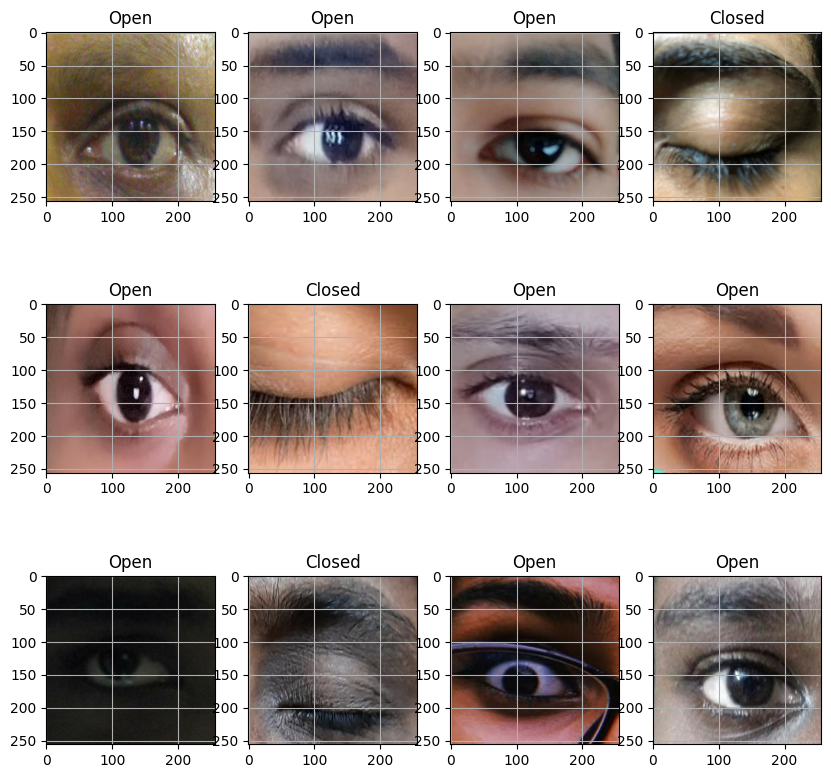

In [51]:
# plotting to inspect images visually
# check labelling  
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(12):
    ax = plt.subplot(3,4 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [24]:
# get the count of batches
# revisit later for what batch size we should have 
batch_count = tf.data.experimental.cardinality(train_images).numpy()
print("Number of batches: " + str(batch_count))

Number of batches: 39


In [33]:
# inspect the batches
for images, labels in train_images.take(1):
    print(images.shape) #(1) denotes the number of images in the batch. (2) denotes the height and width of each image in pixels.(4) denotes the number of color channels in each image, which is typically RGB (red, green, blue) or grayscale.
    print(images.dtype)
    print(labels.shape)
    print(labels.dtype)

(32, 256, 256, 3)
<dtype: 'float32'>
(32,)
<dtype: 'int32'>


In [52]:
# check for smallest and largest image 
from PIL import Image
import os

# Initialize variables to hold the smallest and largest images
smallest_image = None
largest_image = None

smallest_image_size = float('inf')  # set initial smallest size to infinity
largest_image_size = float('-inf')  # set initial largest size to negative infinity

# Iterate over all images in the specified directory
for filename in os.listdir(file_path_folder_train+"/Open/"):
    #if filename.endswith(".jpg") or filename.endswith(".png"):  # add more file types if needed
    img = Image.open(os.path.join(file_path_folder_train+"/Open/", filename))
    width, height = img.size
    image_size = width * height  # total pixel count
    #print("Debug: Image size: " + str(image_size))
    # Check if current image is the smallest one
    if image_size < smallest_image_size:
        smallest_image_size = image_size
        smallest_image = img

    # Check if current image is the largest one
    if image_size > largest_image_size:
        largest_image_size = image_size
        largest_image = img

print("Largest image size: " + str(largest_image_size))
print("Smallest image size: " + str(smallest_image_size))
# Now smallest_image and largest_image hold the smallest and largest images respectively.

Largest image size: 2293710
Smallest image size: 2250


# <font color='red'>PREPROCESS THE DATA</font>

In [55]:
#normalizing the images:
def normalize(images, labels):
    images = images / 255.0
    return images, labels

train_images = train_images.map(normalize)
test_images = test_images.map(normalize)

In [66]:
import cv2
import numpy as np

class DataPreprocessingPipeline:
    def __init__(self, image_size=(256, 256)):
        self.image_size = image_size

    def resize_image(self, image):
        resized_image = cv2.resize(image, self.image_size)
        return resized_image

    def convert_to_grayscale(self, image):
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return grayscale_image

    def denoise_image(self, image):
        denoised_image = cv2.medianBlur(image, 3)
        return denoised_image

    def enhance_contrast(self, image):
        p2, p98 = np.percentile(image, (2, 98))
        enhanced_image = np.clip(image, p2, p98)
        enhanced_image = (enhanced_image - p2) / (p98 - p2)
        return enhanced_image

    def augment_image(self, image):
        # Random rotation
        angle = np.random.randint(-10, 10)
        rows, cols = image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        augmented_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

        # Random horizontal flip
        if np.random.rand() < 0.5:
            augmented_image = cv2.flip(augmented_image, 1)

        return augmented_image

    def preprocess(self, image):
        resized_image = self.resize_image(image)
        grayscale_image = self.convert_to_grayscale(image)
        denoised_image = self.denoise_image(grayscale_image)
        enhanced_image = self.enhance_contrast(denoised_image)
        augmented_image = self.augment_image(enhanced_image)
        return augmented_image

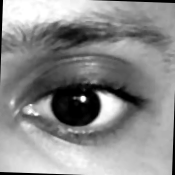

In [96]:
# tesing pipeline on one image 
pipeline = DataPreprocessingPipeline(image_size=(256, 256))

# Load the image
image = cv2.imread("/content/drive/MyDrive/dataset_new/train/Open/_0.jpg")

preprocessed_image = pipeline.preprocess(image)

# The image returned from the pipeline is a floating point image in the range [0, 1] because of the contrast enhancement. 
# We need to convert it back to a 8-bit image in the range [0, 255] before we can display it using PIL.
preprocessed_image = (preprocessed_image * 255).astype(np.uint8)

print_processed_image = Image.fromarray(preprocessed_image) #Using the Image package to assign a viewable image to a new variable.
print_processed_image.show()

# <font color='red'>BUILD THE MODEL</font>

In [74]:
#Set up the layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

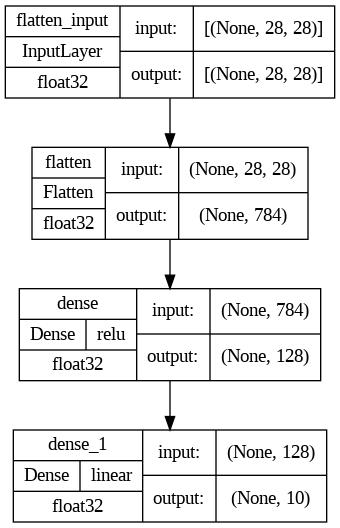

In [75]:
plot_model(
    model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

# <font color='red'>COMPILE THE MODEL</font>

# <font color='blue'> To Do: (1) figure out what compiling does and if we need to add/remove settings.</font>

In [76]:
# setting 
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# <font color='red'>TRAIN THE MODEL</font>

# <font color='blue'> Define X_train, y_train </font>

In [105]:
# Initialize lists to store the images and labels
train_images_list = []
train_labels_list = []

# Iterate over the dataset
for images, labels in train_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    train_images_list.append(flat_images)
    train_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_train = np.concatenate(train_images_list)
y_train = np.concatenate(train_labels_list)

In [106]:
# Initialize lists to store the images and labels
test_images_list = []
test_labels_list = []

# Iterate over the dataset
for images, labels in test_images:
    # Flatten the images
    flat_images = tf.reshape(images, (images.shape[0], -1)).numpy()
    # Append the images and labels to the lists
    test_images_list.append(flat_images)
    test_labels_list.append(labels.numpy())

# Concatenate the list of arrays into a single numpy array
X_test = np.concatenate(test_images_list)
y_test = np.concatenate(test_labels_list)

# <font color='blue'> Dummy Classifier </font>

In [111]:
# Train and evaluate a DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier accuracy: %f" % accuracy_score(y_test, y_pred_dummy))

print("Accuracy on training set: {:.3f}".format(dummy.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dummy.score(X_test, y_test)))

Dummy Classifier accuracy: 0.500000


# <font color='blue'> Logistic Regression </font>

In [116]:
# Train and evaluate a logistic regression model
log_reg = LogisticRegression(max_iter = 100)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Logistic Regression accuracy: %f" % accuracy_score(y_test, y_pred))

#Print the mean accuracy in the training and test data:
print("Accuracy on training set: {:.3f}".format(log_reg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(log_reg.score(X_test, y_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.940367
Accuracy on training set: 1.000
Accuracy on test set: 0.940


In [ ]:
#Getting the optimal parameter from the grid search to set C hyperparameter:
parameters ={"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logr_grid = GridSearchCV(log_reg,parameters, verbose = 2)
logr_grid.fit(X_train,y_train)

print(logr_grid.best_params_,"\n", logr_grid.best_score_)

In [ ]:
#Building the Logistic Regression Model with the best C parameter from GridSearchCV:
logr2 = LogisticRegression() #change the hyperparameters here
logr2.fit(X_train,y_train)

logr_y_pred2 = logr2.predict(X_test_Scaled)

#Print the mean accuracy in the training and test data:
print("Accuracy on training set: {:.3f}".format(logr2.score(X_train_Scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(logr2.score(X_test_Scaled, y_test)))

# <font color='blue'> KNN </font>

In [114]:
# Train and evaluate a KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("KNN accuracy: %f" % accuracy_score(y_test, y_pred))

#Print the mean accuracy in the training and test data:
print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))

KNN accuracy: 0.775229
Accuracy on training set: 0.891
Accuracy on test set: 0.775


In [117]:
#Running GridSearchCV to find optimal hyperparameters for the KNeighborsClassifier:
parameters = {"n_neighbors": np.arange(1,20), "metric": ["euclidean","minkowski","manhattan"], "weights": ["uniform", "distance"]}
knn_grid = GridSearchCV(knn, parameters, verbose = 2)
knn_grid.fit(X_train, y_train)

print(knn_grid.best_params_,"\n", knn_grid.best_score_)

Fitting 5 folds for each of 114 candidates, totalling 570 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   8.5s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   5.9s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   6.8s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   6.2s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   6.1s


KeyboardInterrupt: ignored

In [ ]:
#Verifying that the KNeighborsClassifier performs better with the tuned hyperparameters: 
knn2 = KNeighborsClassifier() #change the hyperparameters here
knn2.fit(X_train,y_train)

knn_y_pred2 = knn2.predict(X_test)

print("Score on training set: {:.3f}".format(knn2.score(X_train, y_train)))
print("Score on test set: {:.3f}".format(knn2.score(X_test, y_test)))

# <font color='blue'> CNN </font>

In [80]:
#FEED THE MODEL
model.fit(
    train_images, 
    train_labels,  
    epochs=10,
    validation_split=0.2,
    callbacks=[PlotLossesKeras()],
    verbose=1,
)

NameError: ignored

# <font color='red'>EVALUATE THE MODEL</font>

In [77]:
train_loss, train_acc = model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


print(f'\nTrain accuracy: {train_acc}\nTest accuracy: {test_acc}')

NameError: ignored

In [78]:
# Use predict_proba 
# revisit class 2 solutions for 
#     probas = knn2.predict_proba(X_test)
#plot the result using plt.hist(probas[:, 1])
#     plt.hist(probas[:, 1])

NameError: ignored

In [ ]:
# print classification report for F1 score etc. 
print(classification_report(y_test, model_pred))

In [ ]:
# print confusion matrix
cm = confusion_matrix(y_test, model_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=dm.classes_)
disp.plot()
plt.show()

# <font color='red'>MAKE PREDICTIONS</font>

In [ ]:
probability_model = tf.keras.Sequential(
    [
        model, 
        tf.keras.layers.Softmax()
    ]
)

In [ ]:
plot_model(
    probability_model, 
    show_shapes=True, 
    show_dtype=True,
    show_layer_names=True, 
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


In [ ]:
predictions[0]

array([0.00002518, 0.        , 0.00000906, 0.00000031, 0.00012651,
       0.00189466, 0.00000843, 0.0089308 , 0.00000139, 0.9890036 ],
      dtype=float32)

In [ ]:
i = random.choice(range(predictions.shape[0]))
pred = np.argmax(predictions[i])
f"Higest probability for class: {pred} ({FASHION_CLASS_NAMES[pred]}) | Correct label: {test_labels[i]} ({FASHION_CLASS_NAMES[test_labels[i]]})"

'Higest probability for class: 6 (Shirt) | Correct label: 6 (Shirt)'

In [ ]:
#Examining the test label shows that this classification is correct:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel(f"{FASHION_CLASS_NAMES[predicted_label]} {100*np.max(predictions_array):2.0f}% ({FASHION_CLASS_NAMES[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(len(FASHION_CLASS_NAMES)), FASHION_CLASS_NAMES, size='small', rotation=30)
  plt.yticks(range(100))
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# <font color='red'>VERIFY PREDICTIONS</font>

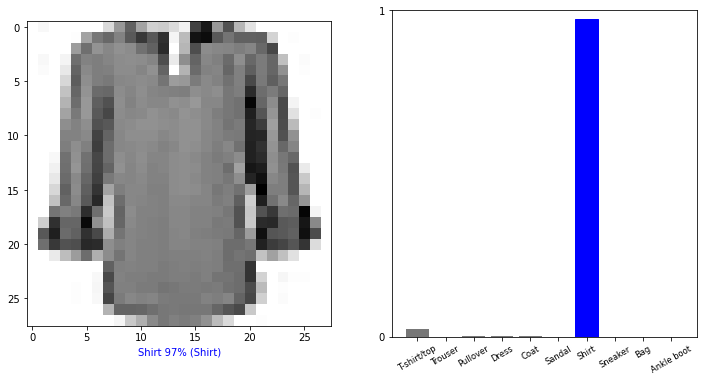

In [ ]:
i = random.choice(range(predictions.shape[0]))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

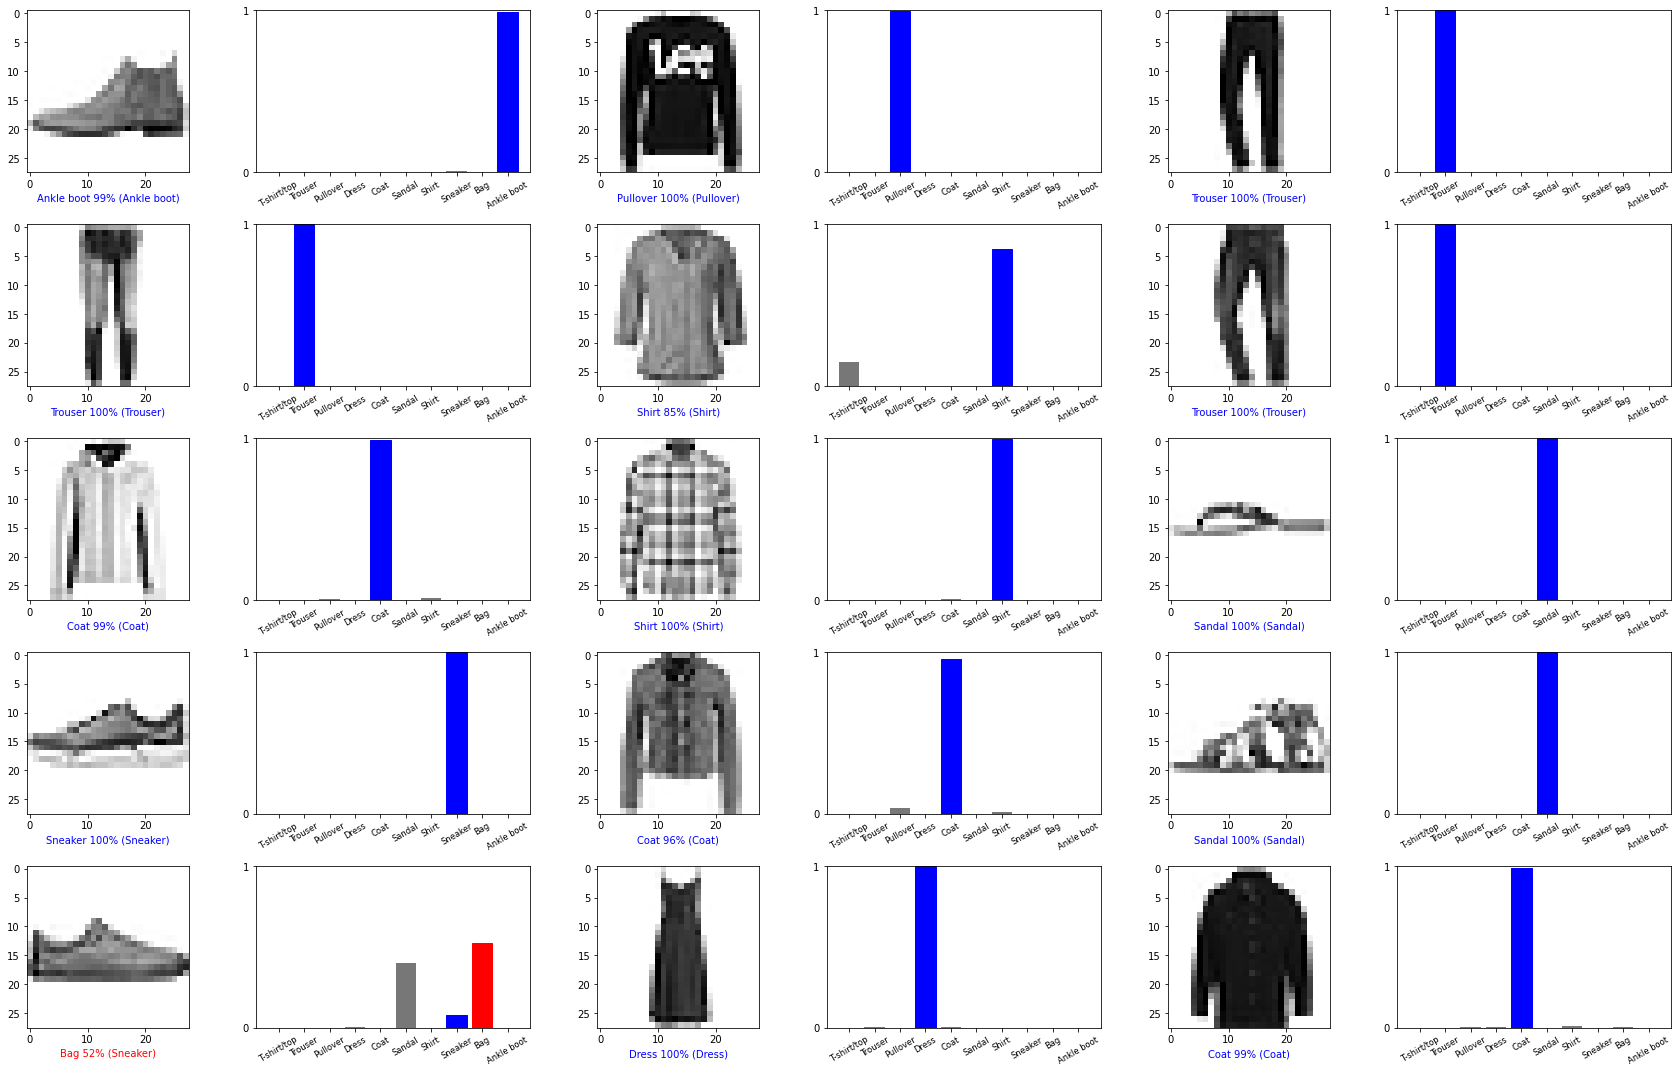

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*4*num_cols, 3*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# <font color='red'>USE THE TRAINED MODEL</font>

In [ ]:
# Grab an image from the test dataset.
i = random.choice(range(test_images.shape[0]))
img = test_images[i]

print(img.shape)

(28, 28)


In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [ ]:
#PREDICT THE CORRECT LABEL
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 18ms/step
[[0.00728808 0.9926932  0.00000525 0.00000167 0.0000005  0.
  0.00001118 0.         0.00000014 0.        ]]


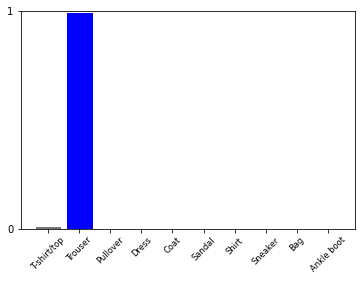

In [ ]:
plot_value_array(
    i, 
    predictions_single[0], 
    test_labels
)
plt.xticks(range(10), FASHION_CLASS_NAMES, rotation=45)
plt.show()

In [ ]:
#Grab the predictions for our (only) image in the batch:
pred_cat = np.argmax(predictions_single[0])
pred_cat, FASHION_CLASS_NAMES[pred_cat]

(1, 'Trouser')